<a href="https://colab.research.google.com/github/EnocPinto/Time-series-analysis-with-Python/blob/main/VARMA_DFF_UNRATE_CPIU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Remove all variables
%reset

In [2]:
#If error importing auto_arima, run this code first
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 58.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [1]:
#Libraries 

#General libraries
import pandas as pd
import numpy as np
from datetime import datetime

#Plotting libraries
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

#Statistical libraries
from statsmodels.tsa.api import VARMAX
from scipy.stats import pearsonr
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# **Table of contents**

1. Exploratory data analysis
    - 1.1 Load and plot data
    - 1.2 Augmented Dickey-Fuller Test (ADF Test) and differentiating
    - 1.3 Pearson correlation coefficient
    - 1.4 Granger-Causality test
    - 1.5 Johansen Cointegration Test
2. VARMA analysis original data
    - 2.1 Data model preparation inverse differentiation and model performance functions
    - 2.2 Auto_arima for model selection
    - 2.3 Model_1 VARMA(2,3)
    - 2.4 Model_1 VARMA(1,1)
    - 2.5 Model_1 VARMA(1,2)
3. VARMA analysis - 7 months lagged predictors
    - 3.1 Data preparation
    - 3.2 Model_1 VARMA(2,3)
    - 3.3 Model_1 VARMA(1,1)
    - 3.4 Model_1 VARMA(1,2)


# **1. Exploratory data analysis**

## **1.1 Load and plot data**

In [2]:
#Load data
DFF = pd.read_csv("DFF.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
UNRATE = pd.read_csv("UNRATE.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
CPIU_monthly = pd.read_csv("CPIU.csv", delimiter = ",")

#Calculate monthly average values for DFF
DFF_monthly = DFF.resample("M").apply(np.mean)

#Add month and year column for merge
DFF_monthly["Year"] = DFF_monthly.index.year
DFF_monthly["Month"] = DFF_monthly.index.month
UNRATE["Year"] = UNRATE.index.year
UNRATE["Month"] = UNRATE.index.month

#Create final dataframe
merge_df = DFF_monthly.merge(UNRATE, how = 'inner', on = ['Year', 'Month'])
final_df = merge_df.merge(CPIU_monthly, how = 'inner', on = ['Year', 'Month'])

#Prepare final DataFrame with all variables for analysis
final_df["DATE"] = pd.to_datetime(final_df[["Year", "Month"]].assign(DAY=1))
final_df = final_df.set_index("DATE")
final_df = final_df.drop(columns=["Month", "Year"])
final_df = final_df.round(2)
final_df

,DFF,UNRATE,CPIU
DATE,,,
1958-01-01,2.72,5.8,3.62
1958-02-01,1.67,6.4,3.25
1958-03-01,1.20,6.7,3.60
1958-04-01,1.26,7.4,3.58
1958-05-01,0.63,7.4,3.21
...,...,...,...
2022-02-01,0.08,3.8,7.87
2022-03-01,0.20,3.6,8.54
2022-04-01,0.33,3.6,8.26


In [3]:
#Summary statistics
final_df.describe().applymap('{:,.2f}'.format)

,DFF,UNRATE,CPIU
count,774.00,774.00,774.00
mean,4.73,5.98,3.68
std,3.68,1.66,2.82
min,0.05,3.40,-2.10
25%,1.77,4.83,1.73
50%,4.59,5.70,2.94
75%,6.54,7.00,4.60
max,19.10,14.70,14.76


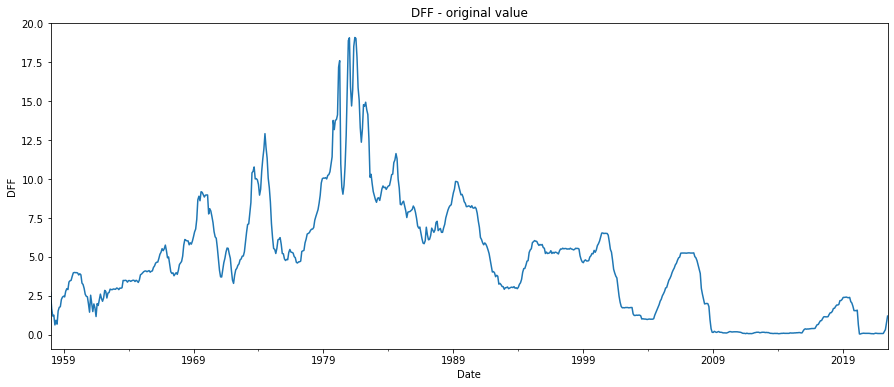

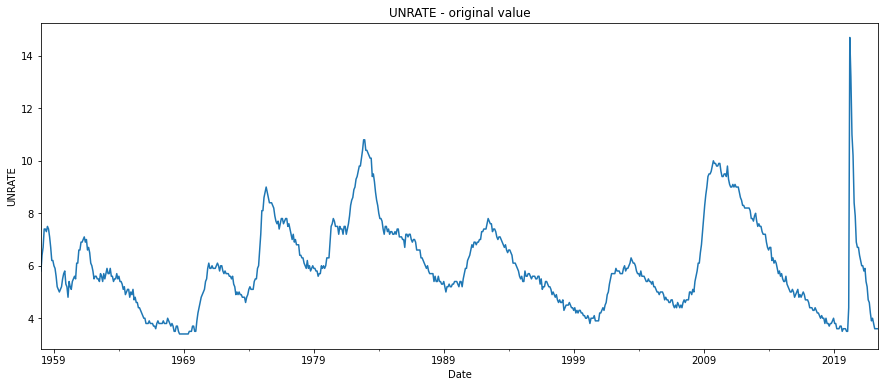

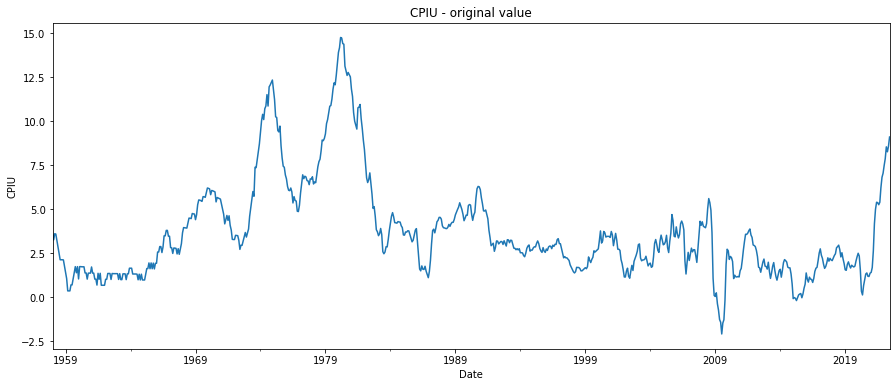

In [4]:
#Plot original variables
for c in final_df[["DFF", "UNRATE", "CPIU"]]:
    final_df[str(c)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} - original value")
    plt.show()

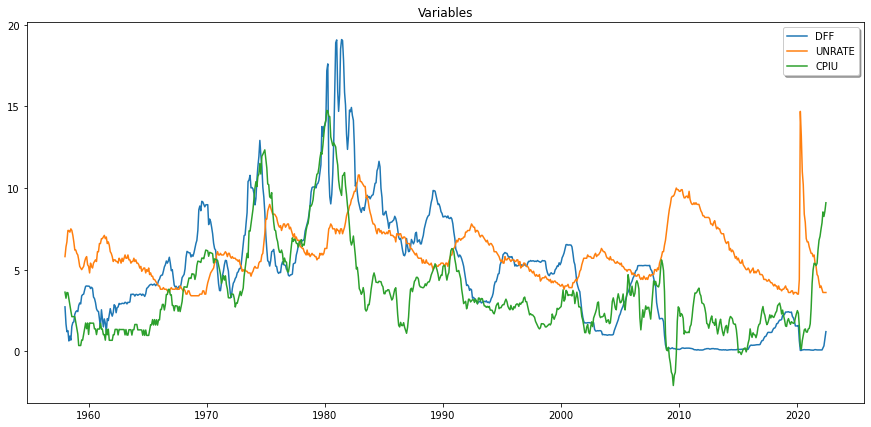

In [5]:
#Plot all variables together
plt.plot("DFF", data = final_df)
plt.plot("UNRATE", data = final_df)
plt.plot("CPIU", data = final_df)
plt.legend(("DFF", "UNRATE", "CPIU"), loc = "upper right", shadow = True)
plt.title("Variables")
plt.show()

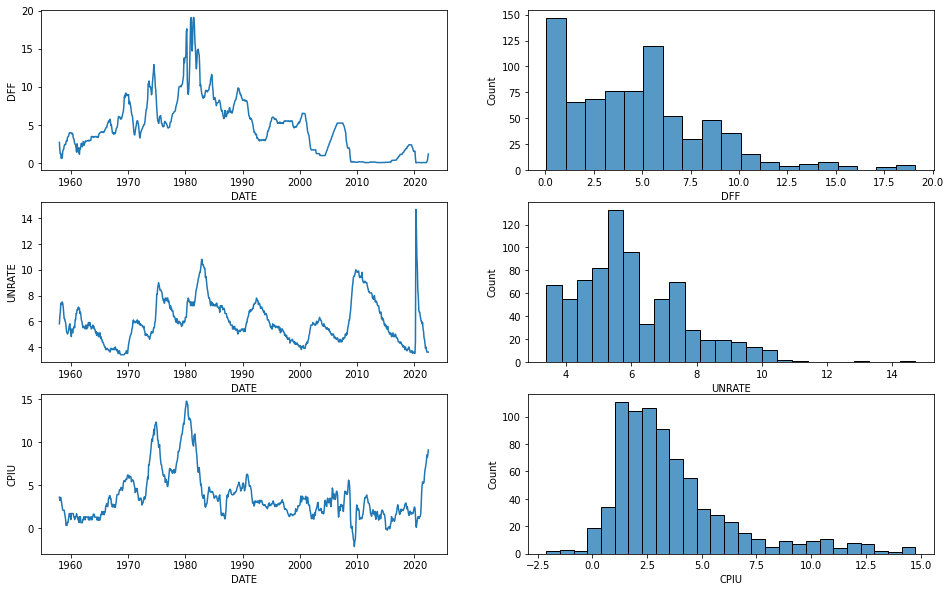

In [6]:
#Plot together line and histogram plots
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(16, 10))
sns.lineplot(data=final_df.DFF, ax=axs[0,0])
sns.histplot(data=final_df.DFF, ax=axs[0,1])
sns.lineplot(data=final_df.UNRATE, ax=axs[1,0])
sns.histplot(data=final_df.UNRATE, ax=axs[1,1])
sns.lineplot(data=final_df.CPIU, ax=axs[2,0])
sns.histplot(data=final_df.CPIU, ax=axs[2,1])

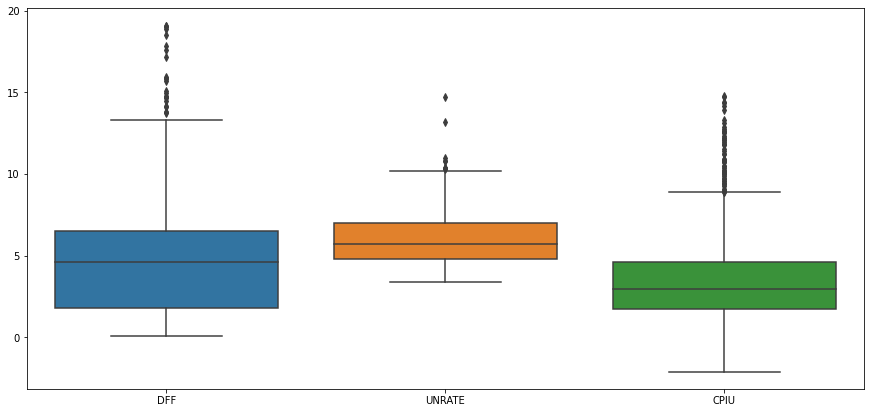

In [7]:
#Boxplot of DFF, UNRATE and CPIU
sns.boxplot(data=final_df)

## **1.2 Augmented Dickey Fuller Test (ADF Test) and differentiating**

In [8]:
#Check if the data is stationary using the Augmented Dickey-Fuller test for CPIU and UNRATE even though we reject #the null hypothesis, 
#we can observe that both time series have a trend

Stationary_test = adfuller(final_df["CPIU"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS CPIU is not stationary")
else:
    print("TS CPIU is stationary")

print(" ----- ")

Stationary_test = adfuller(final_df["UNRATE"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS UNRATED is not stationary")
else:
    print("TS UNRATED is stationary")

Test statistic: -3.0774644712920227
p-value: 0.028266495394058153
TS CPIU is stationary
 ----- 
Test statistic: -3.5243721230409415
p-value: 0.007382788796378324
TS UNRATED is stationary


In [9]:
#Apply 1st order difference although Adfuller returns a p-value less than 0.05
final_df["DFF_diff"] = final_df.DFF.diff(1) 
final_df["UNRATE_diff"] = final_df.UNRATE.diff(1) 
final_df["CPIU_diff"] = final_df.CPIU.diff(1) 
final_df.dropna(inplace=True)
final_df

,DFF,UNRATE,CPIU,DFF_diff,UNRATE_diff,CPIU_diff
DATE,,,,,,
1958-02-01,1.67,6.4,3.25,-1.05,0.6,-0.37
1958-03-01,1.20,6.7,3.60,-0.47,0.3,0.35
1958-04-01,1.26,7.4,3.58,0.06,0.7,-0.02
1958-05-01,0.63,7.4,3.21,-0.63,0.0,-0.37
1958-06-01,0.93,7.3,2.85,0.30,-0.1,-0.36
...,...,...,...,...,...,...
2022-02-01,0.08,3.8,7.87,0.00,-0.2,0.39
2022-03-01,0.20,3.6,8.54,0.12,-0.2,0.67
2022-04-01,0.33,3.6,8.26,0.13,0.0,-0.28


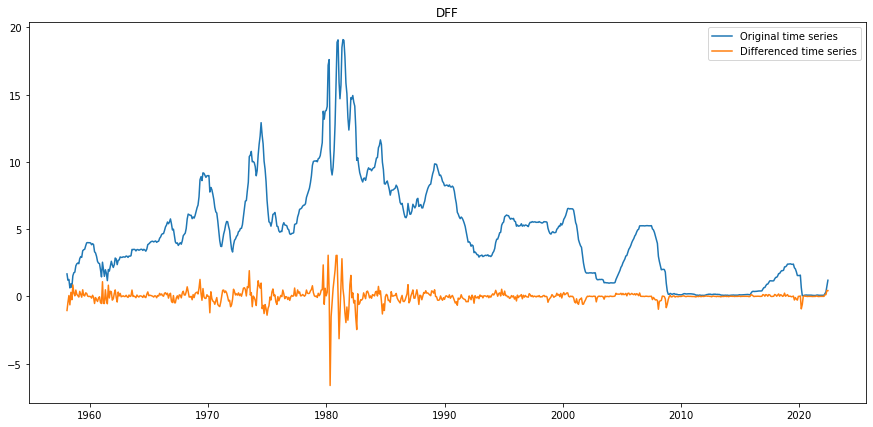

In [10]:
#Plot DFF original and differenced series 
plt.plot(final_df.DFF, label="Original time series")
plt.plot(final_df.DFF_diff, label="Differenced time series")
plt.title("DFF")
plt.legend()

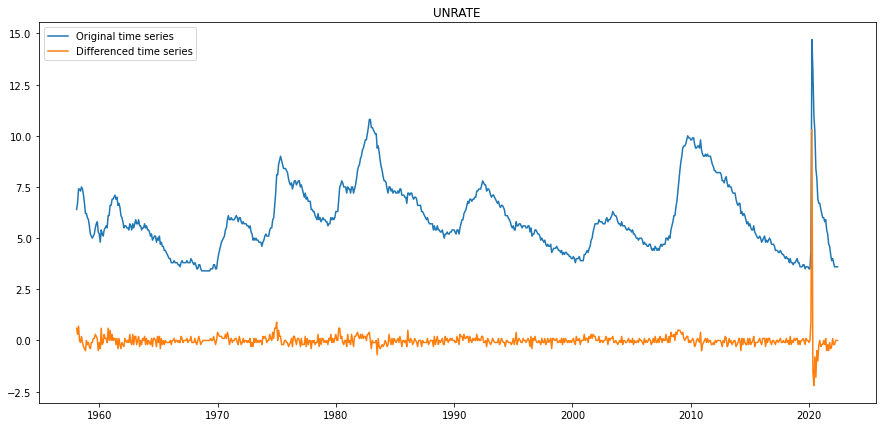

In [11]:
#Plot UNRATE original and differenced series 
plt.plot(final_df.UNRATE, label="Original time series")
plt.plot(final_df.UNRATE_diff, label="Differenced time series")
plt.title("UNRATE")
plt.legend()

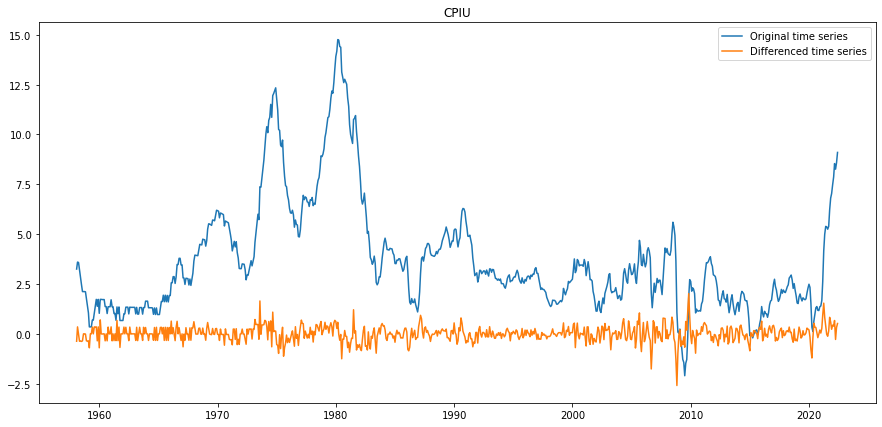

In [12]:
#Plot CPIU original and differenced series 
plt.plot(final_df.CPIU, label="Original time series")
plt.plot(final_df.CPIU_diff, label="Differenced time series")
plt.title("CPIU")
plt.legend()

In [13]:
#Run again the Augmented Dickey–Fuller test for CPIU and UNRATE

Stationary_test = adfuller(final_df["UNRATE_diff"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS CPIU is not stationary")
else:
    print("TS CPIU is stationary")

print(" ----- ")

Stationary_test = adfuller(final_df["CPIU_diff"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS UNRATED is not stationary")
else:
    print("TS UNRATED is stationary")

Test statistic: -20.515191790268336
p-value: 0.0
TS CPIU is stationary
 ----- 
Test statistic: -5.607543760606389
p-value: 1.224437519614562e-06
TS UNRATED is stationary


## **1.3 Pearson correlation coefficient**

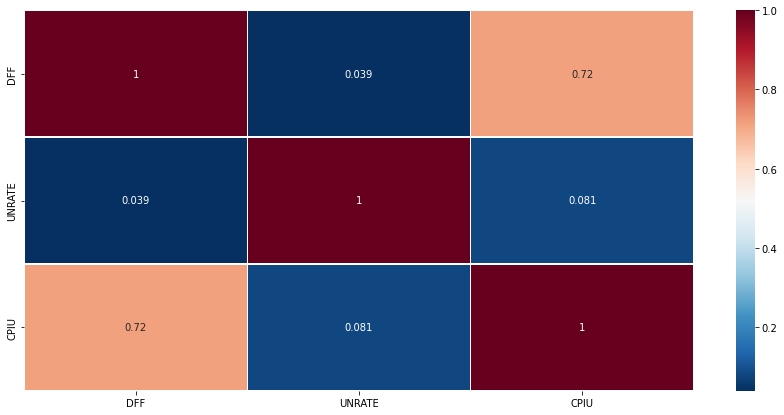

In [14]:
#Plot the Pearson correlation coefficient between the three variables
pearsoncorr = final_df[["DFF",	"UNRATE",	"CPIU"]].corr(method="pearson")
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap="RdBu_r", annot=True, linewidth=0.5)
plt.show()

## **1.4 Granger-Causality test**

In [15]:
#Perform Granger-Causality test DFF vs UNRATE
grangercausalitytests(final_df[["DFF_diff", "UNRATE_diff"]], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4079  , p=0.0653  , df_denom=769, df_num=1
ssr based chi2 test:   chi2=3.4212  , p=0.0644  , df=1
likelihood ratio test: chi2=3.4136  , p=0.0647  , df=1
parameter F test:         F=3.4079  , p=0.0653  , df_denom=769, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4436  , p=0.0875  , df_denom=766, df_num=2
ssr based chi2 test:   chi2=4.9191  , p=0.0855  , df=2
likelihood ratio test: chi2=4.9034  , p=0.0861  , df=2
parameter F test:         F=2.4436  , p=0.0875  , df_denom=766, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3714  , p=0.0692  , df_denom=763, df_num=3
ssr based chi2 test:   chi2=7.1795  , p=0.0664  , df=3
likelihood ratio test: chi2=7.1463  , p=0.0674  , df=3
parameter F test:         F=2.3714  , p=0.0692  , df_denom=763, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1313  , p=0.0752  

{1: ({'ssr_ftest': (3.407871652821784, 0.06527023922311846, 769.0, 1),
   'ssr_chi2test': (3.4211663406741444, 0.06436552332756594, 1),
   'lrtest': (3.413608105876392, 0.06466092137384305, 1),
   'params_ftest': (3.407871652821798, 0.06527023922311846, 769.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.443575502921406, 0.08752652561390954, 766.0, 2),
   'ssr_chi2test': (4.919051469327425, 0.08547547941293118, 2),
   'lrtest': (4.90342589368106, 0.08614589670151716, 2),
   'params_ftest': (2.4435755029215, 0.08752652561390818, 766.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.3714198859264197, 0.06920868823077211, 763.0, 3),
   'ssr_chi2test': (7.179528095006592, 0.0663904888624678, 3),
   'lrtest': (7.146263524889946, 0.06737912560383404, 3),
   'params_ftest': (2.3714198859264397, 0.06920868823076606, 763.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

In [16]:
#Perform Granger-Causality test DFF vs UNRATE
grangercausalitytests(final_df[["DFF_diff", "CPIU_diff"]], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3813  , p=0.2402  , df_denom=769, df_num=1
ssr based chi2 test:   chi2=1.3867  , p=0.2390  , df=1
likelihood ratio test: chi2=1.3855  , p=0.2392  , df=1
parameter F test:         F=1.3813  , p=0.2402  , df_denom=769, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0118  , p=0.1344  , df_denom=766, df_num=2
ssr based chi2 test:   chi2=4.0500  , p=0.1320  , df=2
likelihood ratio test: chi2=4.0394  , p=0.1327  , df=2
parameter F test:         F=2.0118  , p=0.1344  , df_denom=766, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4204  , p=0.2355  , df_denom=763, df_num=3
ssr based chi2 test:   chi2=4.3004  , p=0.2308  , df=3
likelihood ratio test: chi2=4.2884  , p=0.2320  , df=3
parameter F test:         F=1.4204  , p=0.2355  , df_denom=763, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5262  , p=0.1926  

{1: ({'ssr_ftest': (1.3813145752279257, 0.24024111543108115, 769.0, 1),
   'ssr_chi2test': (1.3867033186943543, 0.23896262001644689, 1),
   'lrtest': (1.3854593766825474, 0.23917340134102846, 1),
   'params_ftest': (1.3813145752278977, 0.24024111543113413, 769.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.011846824754079, 0.13444752866291299, 766.0, 2),
   'ssr_chi2test': (4.049957968369178, 0.13199661717522274, 2),
   'lrtest': (4.039358133080896, 0.13269804548983197, 2),
   'params_ftest': (2.011846824754225, 0.13444752866288928, 766.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.4204270048228556, 0.23548661809231639, 763.0, 3),
   'ssr_chi2test': (4.300375335702223, 0.2308025822686671, 3),
   'lrtest': (4.28841127083183, 0.23195796104869879, 3),
   'params_ftest': (1.4204270048229324, 0.2354866180923062, 763.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

## **1.5 Johansen Cointegration Test**

In [17]:
#Johansen test
test_result = coint_johansen(final_df[["DFF",	"CPIU", "UNRATE"]],0,1)

#Get trace statistics and confidence intervals critical values
trace_crit_vals = pd.DataFrame(test_result.trace_stat_crit_vals)
col_names = ["C 90%", "C 95%", "C 99%"]
trace_crit_vals.columns = col_names

trace_stat = test_result.trace_stat
trace_crit_vals.insert(0, "Trace Stat", trace_stat)

max_rank = ["Rank 0", "Rank 1", "Rank 2"]
trace_crit_vals.insert(0, "Maximun Rank", max_rank)

trace_crit_vals

,Maximun Rank,Trace Stat,C 90%,C 95%,C 99%
0,Rank 0,50.756091,27.0669,29.7961,35.4628
1,Rank 1,22.789010,13.4294,15.4943,19.9349
2,Rank 2,7.452450,2.7055,3.8415,6.6349


In [18]:
#Get the Max eigenvalues and confidence intervals critical values
eig_stat_crit_vals = pd.DataFrame(test_result.max_eig_stat_crit_vals)
col_names = ["C 90%", "C 95%", "C 99%"]
eig_stat_crit_vals.columns = col_names

Max_Eig_stat = test_result.max_eig_stat
eig_stat_crit_vals.insert(0, "Max_Eig_stat", trace_stat)

max_rank = ["Rank 0", "Rank 1", "Rank 2"]
eig_stat_crit_vals.insert(0, "Maximun Rank", max_rank)

eig_stat_crit_vals

,Maximun Rank,Max_Eig_stat,C 90%,C 95%,C 99%
0,Rank 0,50.756091,18.8928,21.1314,25.8650
1,Rank 1,22.789010,12.2971,14.2639,18.5200
2,Rank 2,7.452450,2.7055,3.8415,6.6349


# **2. VARMA analysis**

## **2.1 Data model preparation inverse differentiation and model performance functions**

In [19]:
#Train/test split and set up number of out of sample forecast
future_forecast = 12

train_df = final_df[0:-future_forecast]
test_df = final_df[-future_forecast:]

#Print the shape of train_df and test_df
print("train_df shape is {}.".format(train_df.shape))
print("test_df shape is {}.".format(test_df.shape))

train_df shape is (761, 6).
test_df shape is (12, 6).


In [20]:
#Crete a df with the original data
train_original = train_df.loc[:, ["DFF", "UNRATE", "CPIU"]]
train_original.dropna(inplace=True)

#Create a df with the differenced data
train_differenced = train_df.loc[:, ["DFF_diff", "UNRATE_diff", "CPIU_diff"]]
train_differenced.dropna(inplace=True)
train_differenced.rename(columns={"DFF_diff": "DFF", "CPIU_diff": "CPIU", "UNRATE_diff": "UNRATE"}, inplace=True)

In [21]:
#Function to perform the inverse differentiation
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)] = actual_df[col].iloc[0] + df_res[str(col)].cumsum()
    return df_res

In [22]:
#Function to assess model performance
def model_evualuation_metrics (trainY, trainPredict):

  ### Mean Absolute Error (MAE)  
  train_MAE = metrics.mean_absolute_error(trainY, trainPredict)
  print("Model MAE: %.2f" % (train_MAE))
  ### Mean Squared Error (MSE)
  train_MSE = metrics.mean_squared_error(trainY, trainPredict)
  print("Model MSE: %.2f" % (train_MSE))
  ### Root Mean Squared Error(RMSE)
  train_RMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
  print("Model RMSE: %.2f" % (train_RMSE))
  ### R-Squared 
  train_R2 = metrics.r2_score(trainY, trainPredict)
  print("Model R2: %.2f" % (train_R2))

## **2.2 auto_arima for model selection**

In [23]:
#Use auto_arima to find the best p and q values for DFF, UNRATE and CPIU
pq = []
for name, column in train_differenced[["DFF", "UNRATE", "CPIU"]].iteritems():
    print(f"Searching order of p and q for : {name}")
    stepwise_model = auto_arima(train_differenced[name],  trace = True, supress_warnings = True,  information_criterion = "aic", 
                                seasonal=False, approximation=False, stepwise=False)
    parameter = stepwise_model.get_params().get("order")
    print(f"optimal order for:{name} is: {parameter} \n\n")
    pq.append(stepwise_model.get_params().get("order"))

Searching order of p and q for : DFF
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1123.093, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=988.814, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=989.467, Time=0.35 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=991.426, Time=0.38 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=987.997, Time=0.51 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=985.543, Time=0.54 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1004.846, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=989.570, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=987.981, Time=0.56 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=989.929, Time=0.40 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=987.850, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=987.518, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=986.829, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=987.713, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=974.125, 

In [24]:
#Print possible model parameters 
model_params = pd.DataFrame (pq, columns = ["p value", "d value", "q value"])
location=0
new_column = ["DFF", "UNRATE", "CPIU"]  
model_params.insert(loc=location, column="Variable", value=new_column)
model_params

,Variable,p value,d value,q value
0,DFF,2,0,3
1,UNRATE,1,0,1
2,CPIU,1,0,2


## **2.3 Model_1 VARMA(2,3)**

In [25]:
VARMA_1 = VARMAX(train_differenced, order=(2,3))
VARMA_1_fit = VARMA_1.fit(maxiter=1000, disp=False)
print(VARMA_1_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               Statespace Model Results                              
Dep. Variable:     ['DFF', 'UNRATE', 'CPIU']   No. Observations:                  761
Model:                            VARMA(2,3)   Log Likelihood               -1168.640
                                 + intercept   AIC                           2445.279
Date:                       Wed, 12 Oct 2022   BIC                           2695.550
Time:                               17:13:52   HQIC                          2541.648
Sample:                           02-01-1958                                         
                                - 06-01-2021                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):       0.08, 0.01, 0.01   Jarque-Bera (JB):   90335.99, 5835246.33, 361.65
Prob(Q):                  0.78, 0.93, 0.91   Prob(JB):                       0.00, 0.00, 0.00
Heteroskedasticity (H):  0.21, 11.85, 

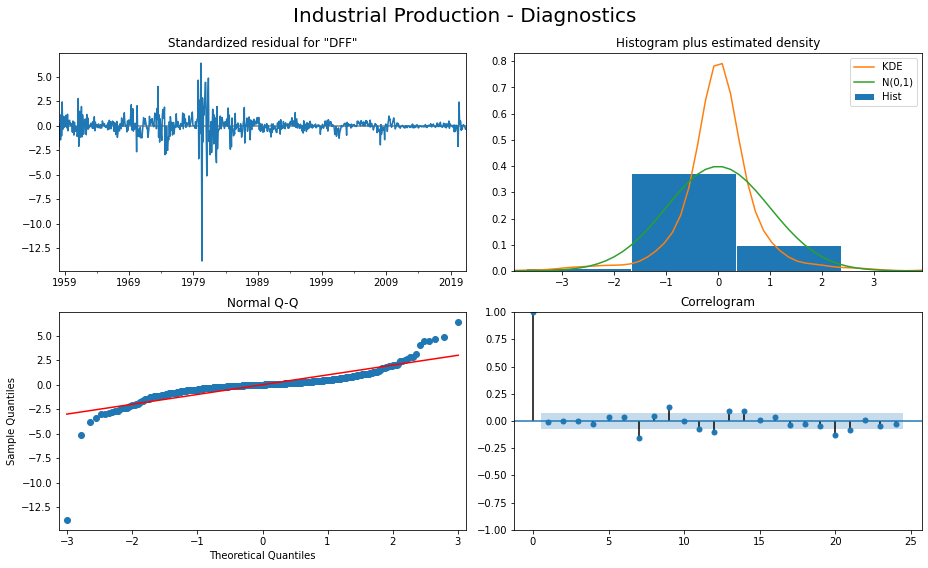

In [26]:
#Residual diagnostic plots
VARMA_1_fit.plot_diagnostics(variable=0, figsize=(13,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

### **Model_1:** In-sample predictions

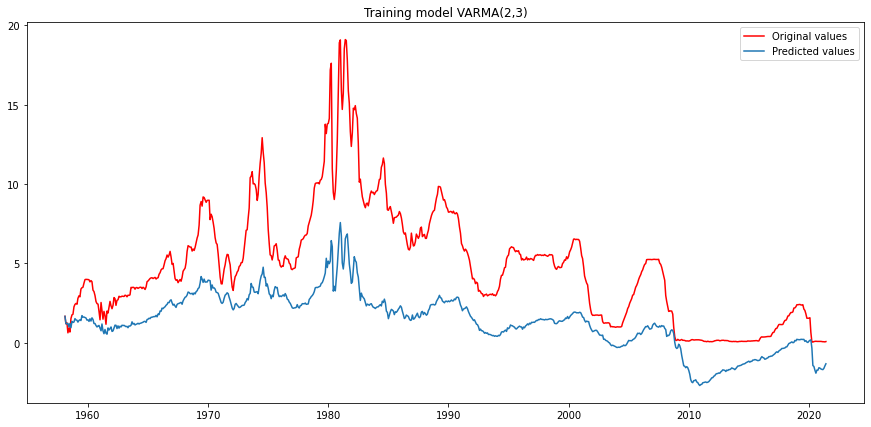

In [27]:
#In sample predictions (training data set)
VARMA_1_InSample_pred = VARMA_1_fit.predict()

#Compute the  the inverse differentiation for training predictions
Inverse_diff_train_1 = inverse_diff(train_original[["DFF",	"CPIU",	"UNRATE"]], VARMA_1_InSample_pred)

#Plot results for DFF as it is our variable of interest
#Although the model also produce forecast values for CPIU and UNRATE 
plt.plot(train_original["DFF"], color = "red", label= "Original values")
plt.plot(Inverse_diff_train_1["DFF"], label = "Predicted values")
plt.title("Training model VARMA(2,3)")
plt.legend(loc="best")
plt.show()

In [28]:
#Model_1 evaluation metrics on training data
VARMA_1_train_performance = model_evualuation_metrics(train_original["DFF"], Inverse_diff_train_1["DFF"])
VARMA_1_train_performance

Model MAE: 3.45
Model MSE: 16.94
Model RMSE: 4.12
Model R2: -0.26


### **Model_1:** Out-of-sample predictions

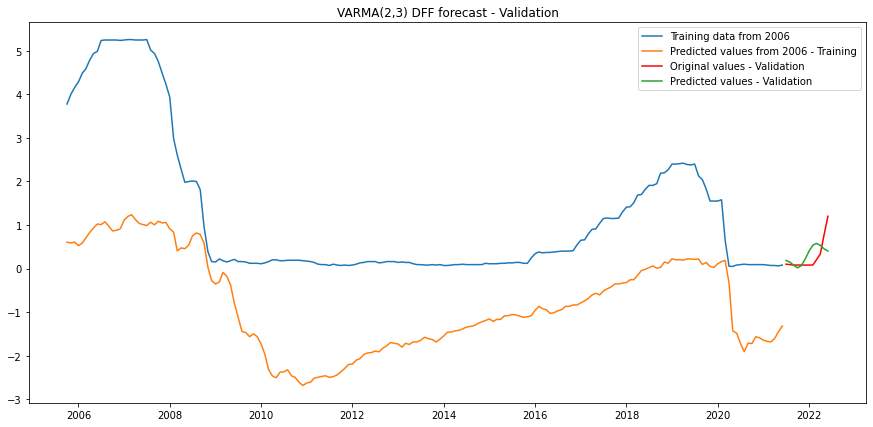

In [29]:
#Out-of sample preictions (testing data set)
VARMA_1_OutOfSample_pred = VARMA_1_fit.forecast(future_forecast)

#Compute the  the inverse differentiation for training predictions
Inverse_diff_test_1 = inverse_diff(test_df[["DFF",	"CPIU",	"UNRATE"]], VARMA_1_OutOfSample_pred)

#Plot results for DFF original and forecast values
plt.plot(train_df.DFF[572:], label= "Training data from 2006")
plt.plot(Inverse_diff_train_1["DFF"][572:], label = "Predicted values from 2006 - Training")
plt.plot(test_df["DFF"], color = "red", label= "Original values - Validation")
plt.plot(Inverse_diff_test_1["DFF"], label = "Predicted values - Validation")
plt.title("VARMA(2,3) DFF forecast - Validation")
plt.legend(loc="best")
plt.show()

In [30]:
#Model evaluation metrics on training data
VARMA_1_test_performance = model_evualuation_metrics(test_df["DFF"], Inverse_diff_test_1["DFF"])
VARMA_1_test_performance

Model MAE: 0.24
Model MSE: 0.11
Model RMSE: 0.32
Model R2: 0.10


In [31]:
#Print original and forecast values
Original_values = pd.DataFrame(test_df["DFF"])
Original_values.columns = ["DFF_Original"]
Forecast_Model1 = pd.DataFrame(Inverse_diff_test_1["DFF"])
model_1_comp = pd.concat([Original_values, Forecast_Model1], axis=1)
model_1_comp.columns = ["DFF_Original", "DFF_forecast_M1"]
model_1_comp

,DFF_Original,DFF_forecast_M1
2021-07-01,0.10,0.183467
2021-08-01,0.09,0.148212
2021-09-01,0.08,0.073011
2021-10-01,0.08,0.015570
2021-11-01,0.08,0.068273
2021-12-01,0.08,0.215718
2022-01-01,0.08,0.398500
2022-02-01,0.08,0.536022
2022-03-01,0.20,0.577569
2022-04-01,0.33,0.532504


## **2.4 Model_2 VARMA(1,1)**

In [32]:
VARMA_2 = VARMAX(train_differenced, order=(1,1))
VARMA_2_fit = VARMA_2.fit(maxiter=1000, disp=False)
print(VARMA_2_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               Statespace Model Results                              
Dep. Variable:     ['DFF', 'UNRATE', 'CPIU']   No. Observations:                  761
Model:                            VARMA(1,1)   Log Likelihood               -1210.090
                                 + intercept   AIC                           2474.179
Date:                       Wed, 12 Oct 2022   BIC                           2599.314
Time:                               17:20:24   HQIC                          2522.364
Sample:                           02-01-1958                                         
                                - 06-01-2021                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):       0.00, 0.02, 0.07   Jarque-Bera (JB):   84988.65, 5247192.45, 451.11
Prob(Q):                  0.98, 0.90, 0.80   Prob(JB):                       0.00, 0.00, 0.00
Heteroskedasticity (H):  0.16, 11.85, 

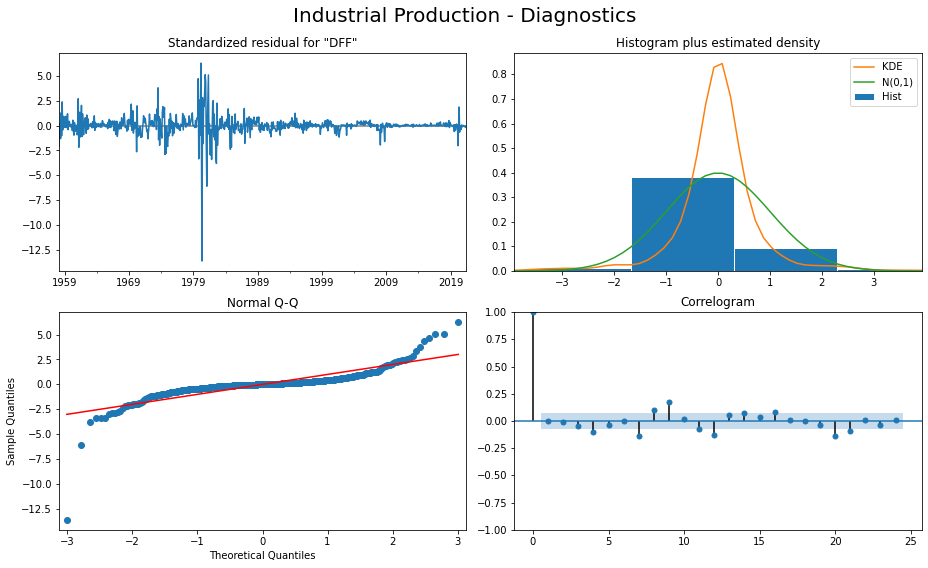

In [33]:
#Residual diagnostic plots
VARMA_2_fit.plot_diagnostics(variable=0, figsize=(13,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

### **Model_2:** In-sample predictions

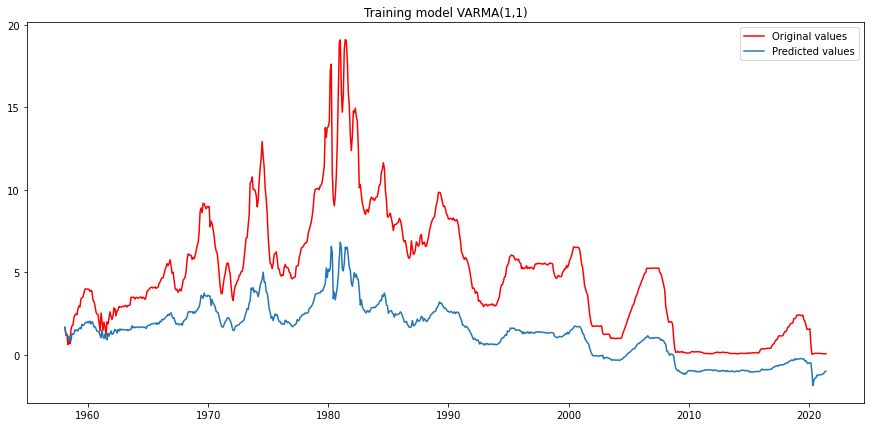

In [34]:
#In sample predictions (training data set)
VARMA_2_InSample_pred = VARMA_2_fit.predict()

#Compute the  the inverse differentiation for training predictions
Inverse_diff_train_2 = inverse_diff(train_original[["DFF",	"CPIU",	"UNRATE"]], VARMA_2_InSample_pred)

#Plot results for DFF as it is our variable of interest
#Although the model also produce forecast values for CPIU and UNRATE 
plt.plot(train_original["DFF"], color = "red", label= "Original values")
plt.plot(Inverse_diff_train_2["DFF"], label = "Predicted values")
plt.title("Training model VARMA(1,1)")
plt.legend(loc="best")
plt.show()

In [35]:
#Model evaluation metrics on training data
VARMA_2_train_performance = model_evualuation_metrics(train_original["DFF"], Inverse_diff_train_2["DFF"])
VARMA_2_train_performance

Model MAE: 3.40
Model MSE: 16.46
Model RMSE: 4.06
Model R2: -0.23


### **Model_2:** Out-of-sample predictions

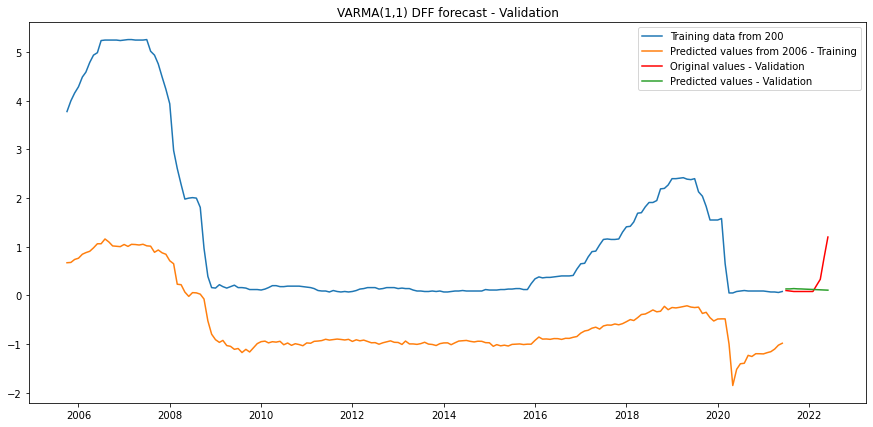

In [36]:
#Out-of sample preictions (testing data set)
VARMA_2_OutOfSample_pred = VARMA_2_fit.forecast(future_forecast)

#Compute the  the inverse differentiation for training predictions
Inverse_diff_test_2 = inverse_diff(test_df[["DFF",	"CPIU",	"UNRATE"]], VARMA_2_OutOfSample_pred)

#Plot results for DFF original and forecast values
plt.plot(train_df.DFF[572:], label= "Training data from 200")
plt.plot(Inverse_diff_train_2["DFF"][572:], label = "Predicted values from 2006 - Training")
plt.plot(test_df["DFF"], color = "red", label= "Original values - Validation")
plt.plot(Inverse_diff_test_2["DFF"], label = "Predicted values - Validation")
plt.title("VARMA(1,1) DFF forecast - Validation")
plt.legend(loc="best")
plt.show()

In [37]:
#Model evaluation metrics on training data
VARMA_2_test_performance = model_evualuation_metrics(test_df["DFF"], Inverse_diff_test_2["DFF"])
VARMA_2_test_performance

Model MAE: 0.20
Model MSE: 0.14
Model RMSE: 0.38
Model R2: -0.21


In [38]:
#Print original and forecast values
Original_values = pd.DataFrame(test_df["DFF"])
Original_values.columns = ["DFF_Original"]
Forecast_Model2 = pd.DataFrame(Inverse_diff_test_2["DFF"])
model_2_comp = pd.concat([Original_values, Forecast_Model2], axis=1)
model_2_comp.columns = ["DFF_Original", "DFF_forecast_M2"]
model_2_comp

,DFF_Original,DFF_forecast_M2
2021-07-01,0.10,0.133090
2021-08-01,0.09,0.133098
2021-09-01,0.08,0.139685
2021-10-01,0.08,0.134299
2021-11-01,0.08,0.132347
2021-12-01,0.08,0.128431
2022-01-01,0.08,0.125087
2022-02-01,0.08,0.121490
2022-03-01,0.20,0.117965
2022-04-01,0.33,0.114412


## **2.5 Model_3 VARMA(1,2)**

In [39]:
VARMA_3 = VARMAX(train_differenced, order=(1,2))
VARMA_3_fit = VARMA_3.fit(maxiter=1000, disp=False)
print(VARMA_3_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               Statespace Model Results                              
Dep. Variable:     ['DFF', 'UNRATE', 'CPIU']   No. Observations:                  761
Model:                            VARMA(1,2)   Log Likelihood               -1190.318
                                 + intercept   AIC                           2452.636
Date:                       Wed, 12 Oct 2022   BIC                           2619.483
Time:                               17:22:17   HQIC                          2516.882
Sample:                           02-01-1958                                         
                                - 06-01-2021                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):       0.77, 0.02, 0.19   Jarque-Bera (JB):   62637.21, 5817398.73, 381.17
Prob(Q):                  0.38, 0.88, 0.67   Prob(JB):                       0.00, 0.00, 0.00
Heteroskedasticity (H):  0.21, 12.86, 

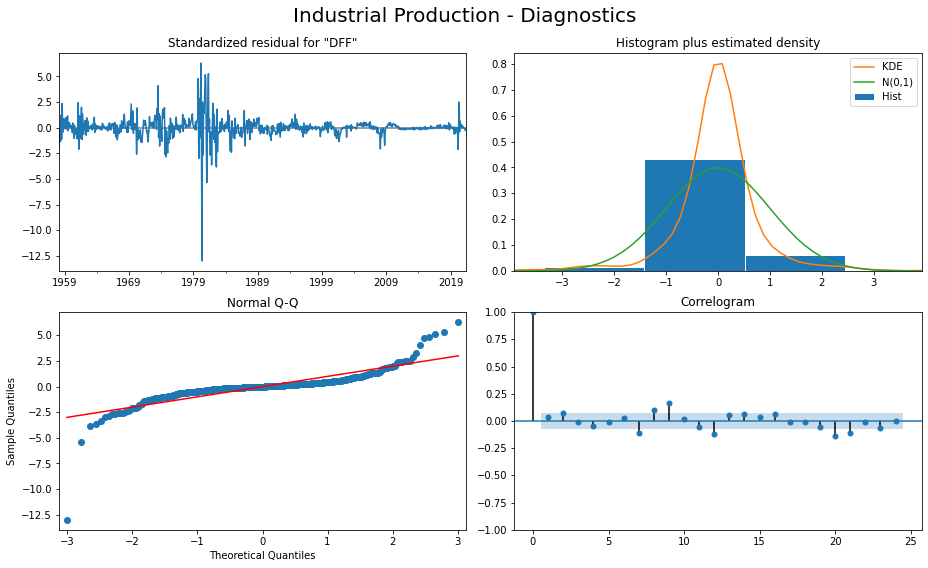

In [40]:
#Residual diagnostic plots
VARMA_3_fit.plot_diagnostics(variable=0, figsize=(13,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

### **Model_3:** In-sample predictions

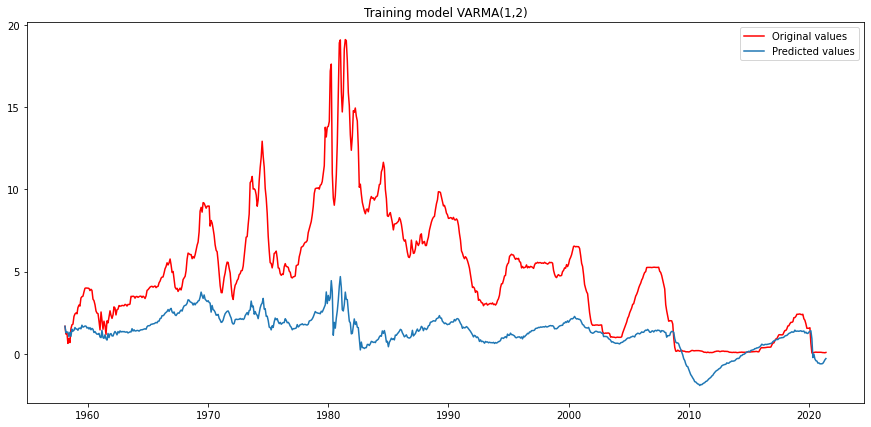

In [41]:
#In sample predictions (training data set)
VARMA_3_InSample_pred = VARMA_3_fit.predict()

#Compute the  the inverse differentiation for training predictions
Inverse_diff_train_3 = inverse_diff(train_original[["DFF",	"CPIU",	"UNRATE"]], VARMA_3_InSample_pred)

#Plot results for DFF as it is our variable of interest
#Although the model also produce forecast values for CPIU and UNRATE 
plt.plot(train_original["DFF"], color = "red", label= "Original values")
plt.plot(Inverse_diff_train_3["DFF"], label = "Predicted values")
plt.title("Training model VARMA(1,2)")
plt.legend(loc="best")
plt.show()

In [42]:
#Model evaluation metrics on training data
VARMA_3_train_performance = model_evualuation_metrics(train_original["DFF"], Inverse_diff_train_3["DFF"])
VARMA_3_train_performance

Model MAE: 3.49
Model MSE: 21.34
Model RMSE: 4.62
Model R2: -0.59


### **Model_3:** Out-of-sample predictions

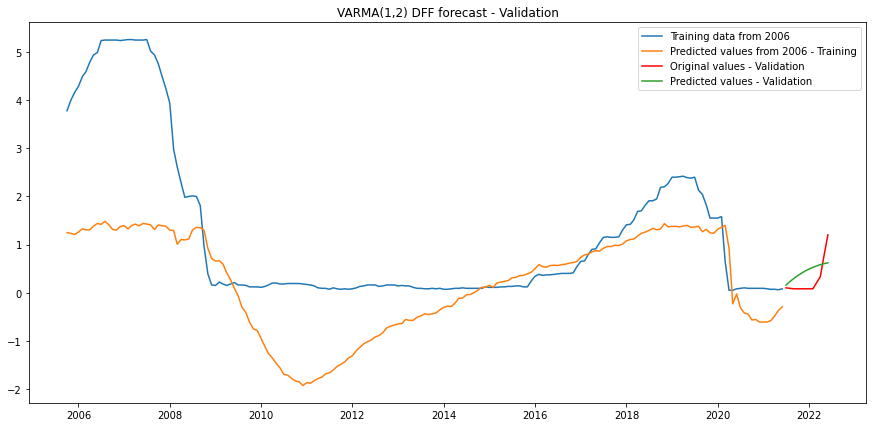

In [43]:
#Out-of sample preictions (testing data set)
VARMA_3_OutOfSample_pred = VARMA_3_fit.forecast(future_forecast)

#Compute the  the inverse differentiation for training predictions
Inverse_diff_test_3 = inverse_diff(test_df[["DFF",	"CPIU",	"UNRATE"]], VARMA_3_OutOfSample_pred)

#Plot results for DFF original and forecast values
plt.plot(train_df.DFF[572:], label= "Training data from 2006")
plt.plot(Inverse_diff_train_3["DFF"][572:], label = "Predicted values from 2006 - Training")
plt.plot(test_df["DFF"], color = "red", label="Original values - Validation")
plt.plot(Inverse_diff_test_3["DFF"], label = "Predicted values - Validation")
plt.title("VARMA(1,2) DFF forecast - Validation")
plt.legend(loc="best")
plt.show()

In [44]:
#Model evaluation metrics on training data
VARMA_3_test_performance = model_evualuation_metrics(test_df["DFF"], Inverse_diff_test_3["DFF"])
VARMA_3_test_performance

Model MAE: 0.30
Model MSE: 0.11
Model RMSE: 0.33
Model R2: 0.07


In [45]:
#Print original and forecast values
Original_values = pd.DataFrame(test_df["DFF"])
Original_values.columns = ["DFF_Original"]
Forecast_Model3 = pd.DataFrame(Inverse_diff_test_3["DFF"])
model_3_comp = pd.concat([Original_values, Forecast_Model3], axis=1)
model_3_comp.columns = ["DFF_Original", "DFF_forecast_M3"]
model_3_comp

,DFF_Original,DFF_forecast_M3
2021-07-01,0.10,0.158612
2021-08-01,0.09,0.230933
2021-09-01,0.08,0.293998
2021-10-01,0.08,0.351790
2021-11-01,0.08,0.403510
2021-12-01,0.08,0.449421
2022-01-01,0.08,0.489742
2022-02-01,0.08,0.524805
2022-03-01,0.20,0.554989
2022-04-01,0.33,0.580701


# **3. VARMA analysis - 7 months lagged predictors**

## **3.1 Data preparation**

In [46]:
#Select DFF and CPIU
final_df = final_df.loc[:, ["DFF", "UNRATE", "CPIU"]]

#Convert the DFF column into a np array and remove the last 7 values
DFF_Adj = final_df["DFF"].values
DFF_Adj = DFF_Adj[:-7]

#Remove the first 7 observations of final_df
final_df_7M_Adj = final_df.iloc[7:]
final_df_7M_Adj = final_df_7M_Adj.drop(columns=["DFF"])
final_df_7M_Adj

#Convine predicted and original validation values
final_df_7M_Adj.insert(0, "DFF", DFF_Adj)
final_df_7M_Adj

,DFF,UNRATE,CPIU
DATE,,,
1958-09-01,1.67,7.1,2.12
1958-10-01,1.20,6.7,2.12
1958-11-01,1.26,6.2,2.11
1958-12-01,0.63,6.2,1.76
1959-01-01,0.93,6.0,1.40
...,...,...,...
2022-02-01,0.10,3.8,7.87
2022-03-01,0.09,3.6,8.54
2022-04-01,0.08,3.6,8.26


In [47]:
#Apply 1st order difference although Adfuller returns a p-value less than 0.05
final_df_7M_Adj["DFF_diff"] = final_df_7M_Adj.DFF.diff(1) 
final_df_7M_Adj["UNRATE_diff"] = final_df_7M_Adj.UNRATE.diff(1) 
final_df_7M_Adj["CPIU_diff"] = final_df_7M_Adj.CPIU.diff(1) 
final_df_7M_Adj.dropna(inplace=True)
final_df_7M_Adj

,DFF,UNRATE,CPIU,DFF_diff,UNRATE_diff,CPIU_diff
DATE,,,,,,
1958-10-01,1.20,6.7,2.12,-0.47,-0.4,0.00
1958-11-01,1.26,6.2,2.11,0.06,-0.5,-0.01
1958-12-01,0.63,6.2,1.76,-0.63,0.0,-0.35
1959-01-01,0.93,6.0,1.40,0.30,-0.2,-0.36
1959-02-01,0.68,5.9,1.05,-0.25,-0.1,-0.35
...,...,...,...,...,...,...
2022-02-01,0.10,3.8,7.87,0.02,-0.2,0.39
2022-03-01,0.09,3.6,8.54,-0.01,-0.2,0.67
2022-04-01,0.08,3.6,8.26,-0.01,0.0,-0.28


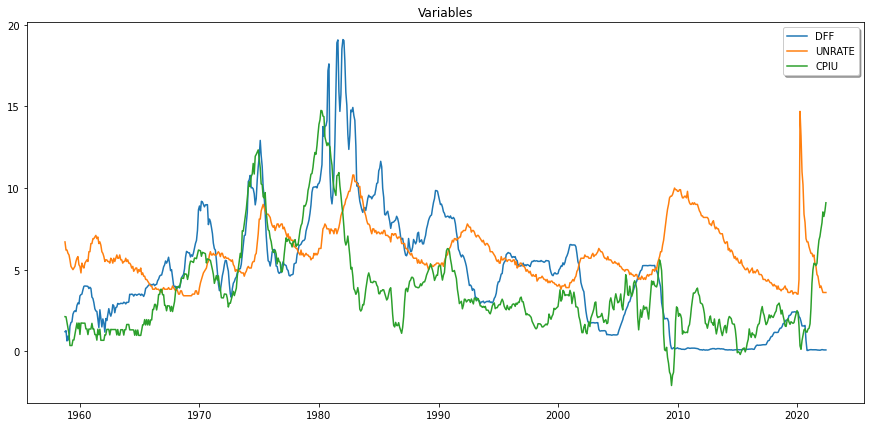

In [48]:
#Plot all variables together UNRATE AND CPIU lagged 7 months compared to DFF
plt.plot("DFF", data = final_df_7M_Adj)
plt.plot("UNRATE", data = final_df_7M_Adj)
plt.plot("CPIU", data = final_df_7M_Adj)
plt.legend(("DFF", "UNRATE", "CPIU"), loc = "upper right", shadow = True)
plt.title("Variables")
plt.show()

In [49]:
#Train/test split and set up number of out of sample forecast

future_forecast = 12

train_df_7M = final_df_7M_Adj[0:-future_forecast]
test_df_7M = final_df_7M_Adj[-future_forecast:]

#Print the shape of train_df and test_df
print("train_df_7M shape is {}.".format(train_df_7M.shape))
print("test_df_7M shape is {}.".format(test_df_7M.shape))

train_df_7M shape is (753, 6).
test_df_7M shape is (12, 6).


In [51]:
#Crete a df with the original data
train_original_7M = train_df_7M.loc[:, ["DFF", "UNRATE", "CPIU"]]
train_original_7M.dropna(inplace=True)

#Create a df with the differenced data
train_differenced_7M = train_df_7M.loc[:, ["DFF_diff", "UNRATE_diff", "CPIU_diff"]]
train_differenced_7M.dropna(inplace=True)
train_differenced_7M.rename(columns={"DFF_diff": "DFF", "CPIU_diff": "CPIU", "UNRATE_diff": "UNRATE"}, inplace=True)

## **3.2 Model_1_7M VARMA(2,3)**

In [52]:
VARMA_1_7M = VARMAX(train_differenced_7M, order=(2,3))
VARMA_1_7M_fit = VARMA_1_7M.fit(maxiter=1000, disp=False)
print(VARMA_1_7M_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               Statespace Model Results                              
Dep. Variable:     ['DFF', 'UNRATE', 'CPIU']   No. Observations:                  753
Model:                            VARMA(2,3)   Log Likelihood               -1165.423
                                 + intercept   AIC                           2438.845
Date:                       Wed, 12 Oct 2022   BIC                           2688.545
Time:                               17:25:27   HQIC                          2535.042
Sample:                           10-01-1958                                         
                                - 06-01-2021                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):       0.02, 0.03, 0.01   Jarque-Bera (JB):   66549.51, 5467621.87, 472.08
Prob(Q):                  0.90, 0.87, 0.92   Prob(JB):                       0.00, 0.00, 0.00
Heteroskedasticity (H):  0.27, 10.67, 

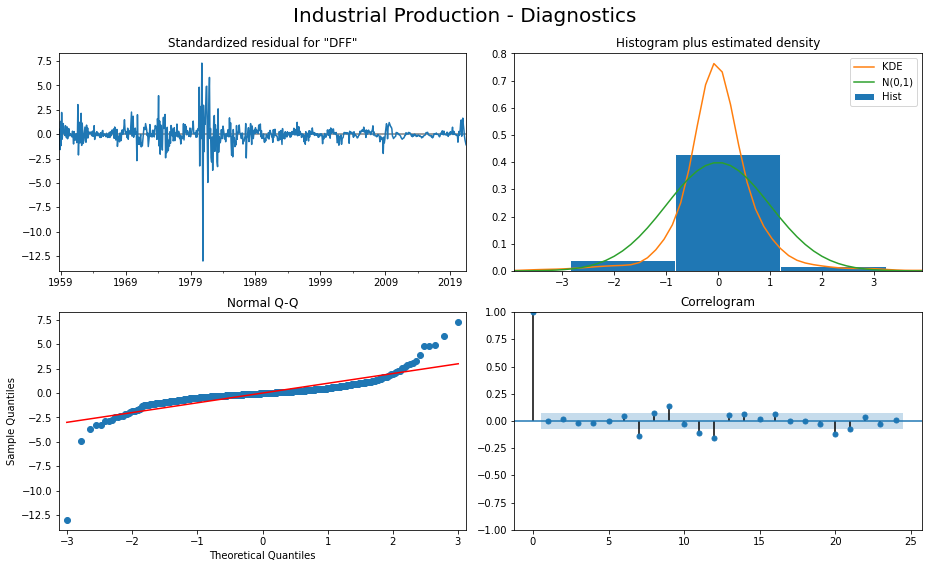

In [53]:
#Residual diagnostic plots
VARMA_1_7M_fit.plot_diagnostics(variable=0, figsize=(13,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

### **Model_1_7M:** In-sample predictions

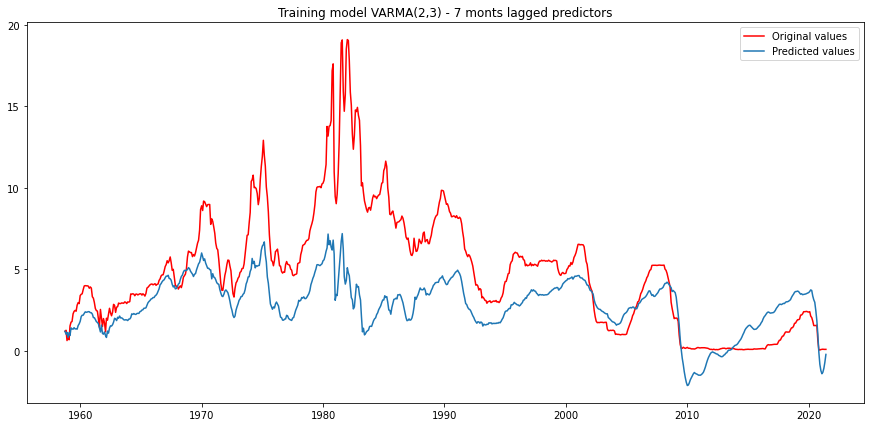

In [54]:
#In sample predictions (training data set)
VARMA_1_InSample_pred = VARMA_1_7M_fit.predict()

#Compute the  the inverse differentiation for training predictions
Inverse_diff_train_1 = inverse_diff(train_original_7M[["DFF",	"CPIU",	"UNRATE"]], VARMA_1_InSample_pred)

#Plot results for DFF as it is our variable of interest
#Although the model also produce forecast values for CPIU and UNRATE 
plt.plot(train_df_7M["DFF"], color = "red", label= "Original values")
plt.plot(Inverse_diff_train_1["DFF"], label = "Predicted values")
plt.title("Training model VARMA(2,3) - 7 monts lagged predictors")
plt.legend(loc="best")
plt.show()

In [55]:
#Model evaluation metrics on training data
VARMA_1_train_performance = model_evualuation_metrics(train_original_7M["DFF"], Inverse_diff_train_1["DFF"])
VARMA_1_train_performance

Model MAE: 2.46
Model MSE: 11.79
Model RMSE: 3.43
Model R2: 0.12


### **Model_1_7M:** Out-of-sample predictions

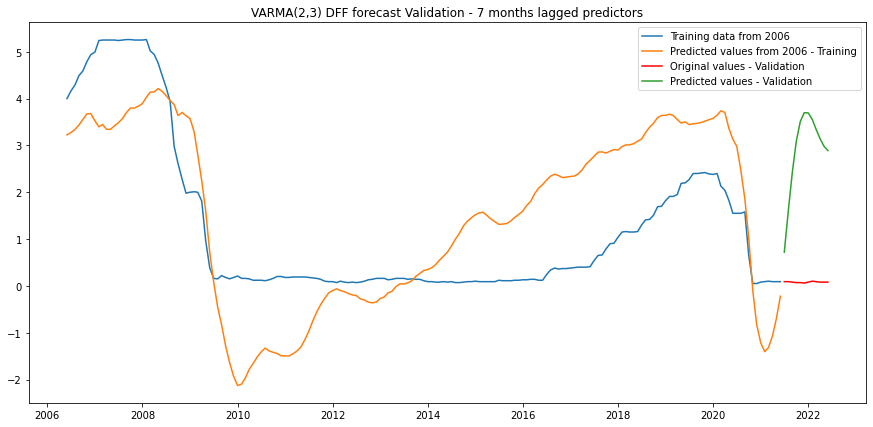

In [56]:
#Out-of sample preictions (testing data set)
VARMA_1_OutOfSample_pred = VARMA_1_7M_fit.forecast(future_forecast)

#Compute the  the inverse differentiation for training predictions
Inverse_diff_test_1 = inverse_diff(test_df_7M[["DFF",	"CPIU",	"UNRATE"]], VARMA_1_OutOfSample_pred)

#Plot results for DFF original and forecast values
plt.plot(train_df_7M.DFF[572:], label= "Training data from 2006")
plt.plot(Inverse_diff_train_1["DFF"][572:], label = "Predicted values from 2006 - Training")
plt.plot(test_df_7M["DFF"], color = "red", label= "Original values - Validation")
plt.plot(Inverse_diff_test_1["DFF"], label = "Predicted values - Validation")
plt.title("VARMA(2,3) DFF forecast Validation - 7 months lagged predictors")
plt.legend(loc="best")
plt.show()

In [57]:
#Model evaluation metrics on training data
VARMA_1_test_performance = model_evualuation_metrics(test_df_7M["DFF"], Inverse_diff_test_1["DFF"])
VARMA_1_test_performance

Model MAE: 2.81
Model MSE: 8.65
Model RMSE: 2.94
Model R2: -80349.92


In [58]:
#Print original and forecast values
Original_values = pd.DataFrame(test_df_7M["DFF"])
Original_values.columns = ["DFF_Original"]
Forecast_Model1 = pd.DataFrame(Inverse_diff_test_1["DFF"])
model_1_comp = pd.concat([Original_values, Forecast_Model1], axis=1)
model_1_comp.columns = ["DFF_Original", "DFF_forecast_M1"]
model_1_comp

,DFF_Original,DFF_forecast_M1
2021-07-01,0.09,0.719960
2021-08-01,0.09,1.605646
2021-09-01,0.08,2.432289
2021-10-01,0.07,3.084709
2021-11-01,0.07,3.509204
2021-12-01,0.06,3.698795
2022-01-01,0.08,3.693712
2022-02-01,0.10,3.554901
2022-03-01,0.09,3.353029
2022-04-01,0.08,3.148677


## **3.3 Model_2_7M VARMA(1,1)**

In [59]:
VARMA_2_7M = VARMAX(train_differenced_7M, order=(1,1))
VARMA_2_7M_fit = VARMA_2_7M.fit(maxiter=1000, disp=False)
print(VARMA_2_7M_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               Statespace Model Results                              
Dep. Variable:     ['DFF', 'UNRATE', 'CPIU']   No. Observations:                  753
Model:                            VARMA(1,1)   Log Likelihood               -1215.002
                                 + intercept   AIC                           2484.004
Date:                       Wed, 12 Oct 2022   BIC                           2608.853
Time:                               17:26:49   HQIC                          2532.102
Sample:                           10-01-1958                                         
                                - 06-01-2021                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):       0.00, 1.61, 0.01   Jarque-Bera (JB):   87312.94, 5490616.51, 388.54
Prob(Q):                  0.99, 0.20, 0.93   Prob(JB):                       0.00, 0.00, 0.00
Heteroskedasticity (H):  0.15, 11.65, 

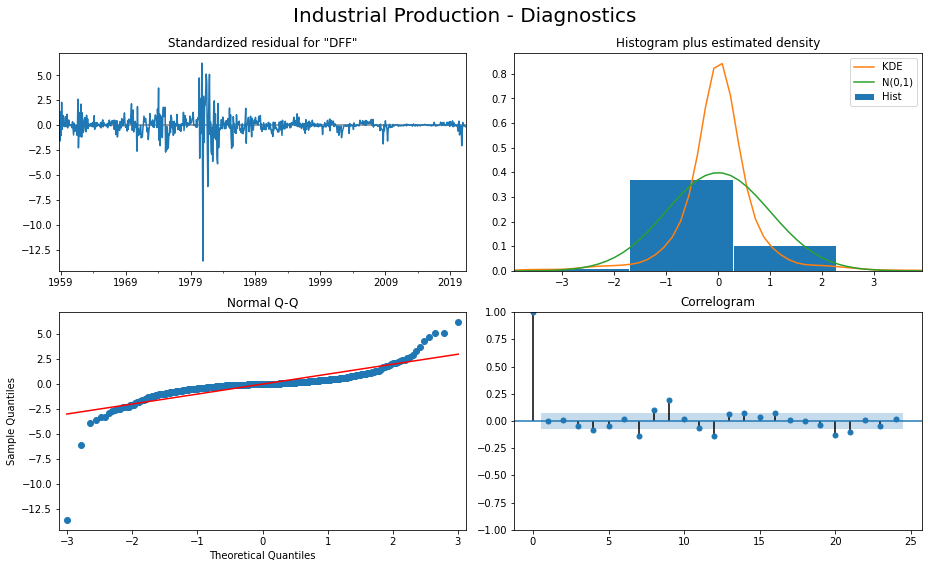

In [60]:
#Residual diagnostic plots
VARMA_2_7M_fit.plot_diagnostics(variable=0, figsize=(13,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

### **Model_2_7M:** In-sample predictions

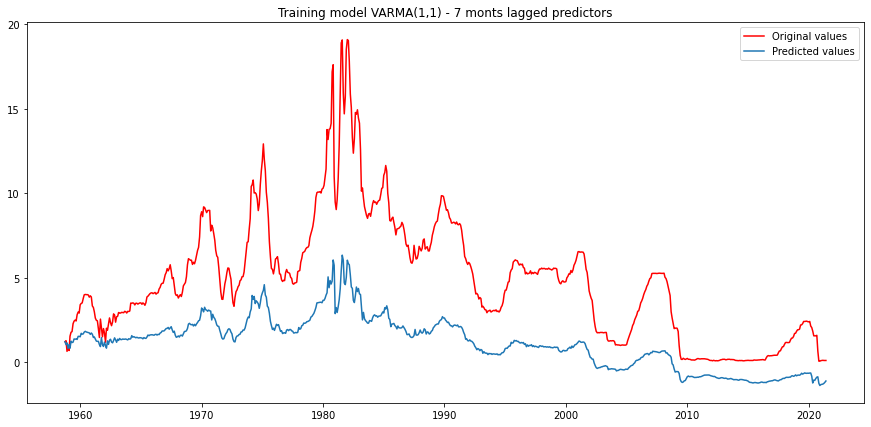

In [61]:
#In sample predictions (training data set)
VARMA_2_InSample_pred = VARMA_2_7M_fit.predict()

#Compute the  the inverse differentiation for training predictions
Inverse_diff_train_2 = inverse_diff(train_original_7M[["DFF",	"CPIU",	"UNRATE"]], VARMA_2_InSample_pred)

#Plot results for DFF as it is our variable of interest
#Although the model also produce forecast values for CPIU and UNRATE 
plt.plot(train_df_7M["DFF"], color = "red", label= "Original values")
plt.plot(Inverse_diff_train_2["DFF"], label = "Predicted values")
plt.title("Training model VARMA(1,1) - 7 monts lagged predictors")
plt.legend(loc="best")
plt.show()

In [62]:
#Model evaluation metrics on training data
VARMA_2_train_performance = model_evualuation_metrics(train_original_7M["DFF"], Inverse_diff_train_2["DFF"])
VARMA_2_train_performance

Model MAE: 3.71
Model MSE: 19.11
Model RMSE: 4.37
Model R2: -0.43


### **Model_2_7M:** Out-of-sample predictions

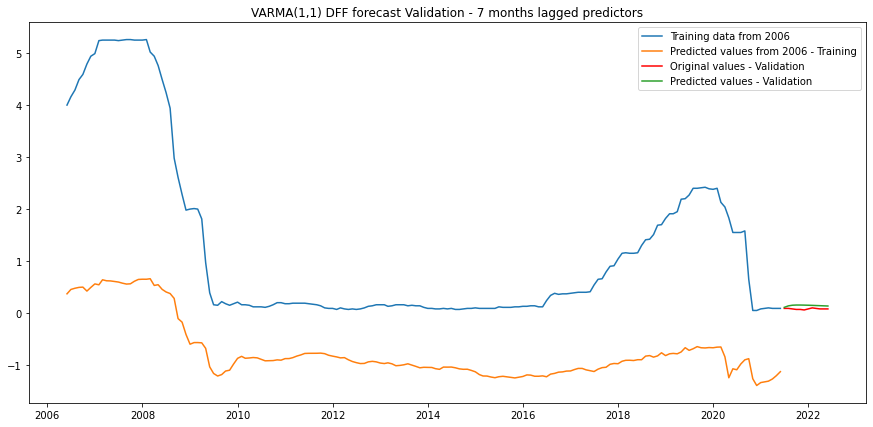

In [63]:
#Out-of sample preictions (testing data set)
VARMA_2_OutOfSample_pred = VARMA_2_7M_fit.forecast(future_forecast)

#Compute the  the inverse differentiation for training predictions
Inverse_diff_test_2 = inverse_diff(test_df_7M[["DFF",	"CPIU",	"UNRATE"]], VARMA_2_OutOfSample_pred)

#Plot results for DFF original and forecast values
plt.plot(train_df_7M.DFF[572:], label= "Training data from 2006")
plt.plot(Inverse_diff_train_2["DFF"][572:], label = "Predicted values from 2006 - Training")
plt.plot(test_df_7M["DFF"], color = "red", label= "Original values - Validation")
plt.plot(Inverse_diff_test_2["DFF"], label = "Predicted values - Validation")
plt.title("VARMA(1,1) DFF forecast Validation - 7 months lagged predictors")
plt.legend(loc="best")
plt.show()

In [64]:
#Model evaluation metrics on training data
VARMA_2_test_performance = model_evualuation_metrics(test_df_7M["DFF"], Inverse_diff_test_2["DFF"])
VARMA_2_test_performance

Model MAE: 0.06
Model MSE: 0.00
Model RMSE: 0.07
Model R2: -38.95


In [65]:
#Print original and forecast values
Original_values = pd.DataFrame(test_df_7M["DFF"])
Original_values.columns = ["DFF_Original"]
Forecast_Model2 = pd.DataFrame(Inverse_diff_test_2["DFF"])
model_2_comp = pd.concat([Original_values, Forecast_Model2], axis=1)
model_2_comp.columns = ["DFF_Original", "DFF_forecast_M2"]
model_2_comp

,DFF_Original,DFF_forecast_M2
2021-07-01,0.09,0.109883
2021-08-01,0.09,0.138488
2021-09-01,0.08,0.150885
2021-10-01,0.07,0.154598
2021-11-01,0.07,0.154598
2021-12-01,0.06,0.153029
2022-01-01,0.08,0.150746
2022-02-01,0.10,0.148097
2022-03-01,0.09,0.145232
2022-04-01,0.08,0.142225


## **3.4 Model_3_7M VARMA(1,2)**

In [66]:
VARMA_3_7M = VARMAX(train_differenced_7M, order=(1,2))
VARMA_3_7M_fit = VARMA_3_7M.fit(maxiter=1000, disp=False)
print(VARMA_3_7M_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               Statespace Model Results                              
Dep. Variable:     ['DFF', 'UNRATE', 'CPIU']   No. Observations:                  753
Model:                            VARMA(1,2)   Log Likelihood               -1187.344
                                 + intercept   AIC                           2446.688
Date:                       Wed, 12 Oct 2022   BIC                           2613.154
Time:                               17:28:13   HQIC                          2510.819
Sample:                           10-01-1958                                         
                                - 06-01-2021                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):       0.27, 0.28, 0.00   Jarque-Bera (JB):   80319.40, 5305964.72, 414.37
Prob(Q):                  0.60, 0.60, 0.95   Prob(JB):                       0.00, 0.00, 0.00
Heteroskedasticity (H):  0.17, 12.22, 

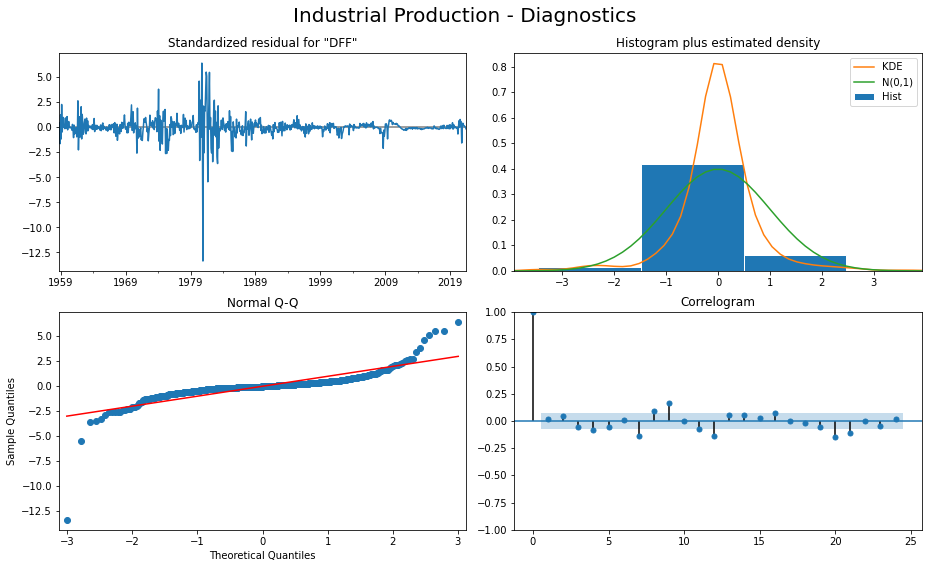

In [67]:
#Residual diagnostic plots
VARMA_3_7M_fit.plot_diagnostics(variable=0, figsize=(13,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

### **Model_3_7M:** In-sample predictions

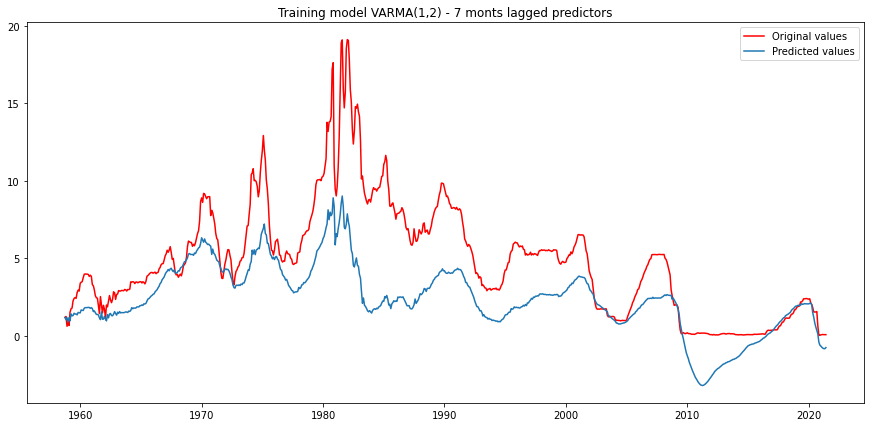

In [68]:
#In sample predictions (training data set)
VARMA_3_InSample_pred = VARMA_3_7M_fit.predict()

#Compute the  the inverse differentiation for training predictions
Inverse_diff_train_3 = inverse_diff(train_original_7M[["DFF",	"CPIU",	"UNRATE"]], VARMA_3_InSample_pred)

#Plot results for DFF as it is our variable of interest
#Although the model also produce forecast values for CPIU and UNRATE 
plt.plot(train_df_7M["DFF"], color = "red", label= "Original values")
plt.plot(Inverse_diff_train_3["DFF"], label = "Predicted values")
plt.title("Training model VARMA(1,2) - 7 monts lagged predictors")
plt.legend(loc="best")
plt.show()

In [69]:
#Model evaluation metrics on training data
VARMA_3_train_performance = model_evualuation_metrics(train_original_7M["DFF"], Inverse_diff_train_3["DFF"])
VARMA_3_train_performance

Model MAE: 2.47
Model MSE: 11.03
Model RMSE: 3.32
Model R2: 0.17


### **Model_3_7M:** Out-of-sample predictions

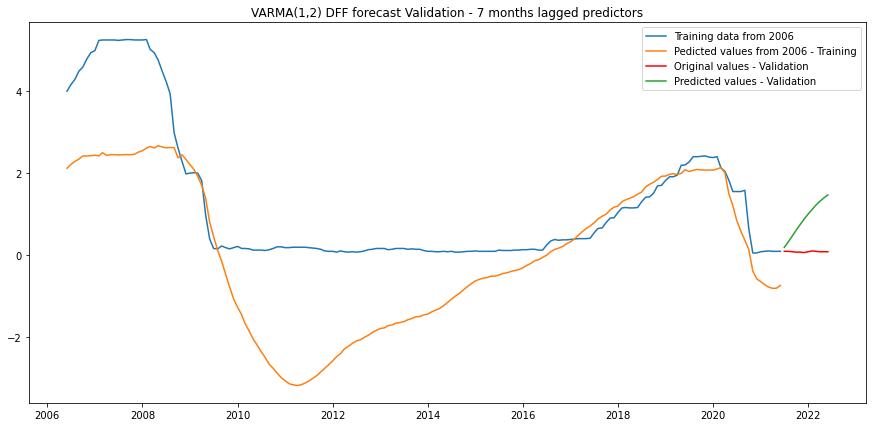

In [70]:
#Out-of sample preictions (testing data set)
VARMA_3_OutOfSample_pred = VARMA_3_7M_fit.forecast(future_forecast)

#Compute the  the inverse differentiation for training predictions
Inverse_diff_test_3 = inverse_diff(test_df_7M[["DFF",	"CPIU",	"UNRATE"]], VARMA_3_OutOfSample_pred)

#Plot results for DFF original and forecast values
plt.plot(train_df_7M.DFF[572:], label= "Training data from 2006")
plt.plot(Inverse_diff_train_3["DFF"][572:], label = "Pedicted values from 2006 - Training")
plt.plot(test_df_7M["DFF"], color = "red", label= "Original values - Validation")
plt.plot(Inverse_diff_test_3["DFF"], label = "Predicted values - Validation")
plt.title("VARMA(1,2) DFF forecast Validation - 7 months lagged predictors")
plt.legend(loc="best")
plt.show()

In [71]:
#Model evaluation metrics on training data
VARMA_3_test_performance = model_evualuation_metrics(test_df_7M["DFF"], Inverse_diff_test_3["DFF"])
VARMA_3_test_performance

Model MAE: 0.81
Model MSE: 0.83
Model RMSE: 0.91
Model R2: -7709.78


In [72]:
#Print original and forecast values
Original_values = pd.DataFrame(test_df_7M["DFF"])
Original_values.columns = ["DFF_Original"]
Forecast_Model3 = pd.DataFrame(Inverse_diff_test_3["DFF"])
model_3_comp = pd.concat([Original_values, Forecast_Model3], axis=1)
model_3_comp.columns = ["DFF_Original", "DFF_forecast_M2"]
model_3_comp

,DFF_Original,DFF_forecast_M2
2021-07-01,0.09,0.186023
2021-08-01,0.09,0.321259
2021-09-01,0.08,0.467378
2021-10-01,0.07,0.609148
2021-11-01,0.07,0.747917
2021-12-01,0.06,0.879252
2022-01-01,0.08,1.002328
2022-02-01,0.10,1.115696
2022-03-01,0.09,1.218933
2022-04-01,0.08,1.311777
